In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix,classification_report
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from transformers import pipeline
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from keras.layers import Bidirectional

In [8]:
df = pd.read_csv('data/hasilPreprocessing.csv')
df

,cleaned_text
0,body ev buat bauksit juga milik indonesia ketu...
1,baterai rupa komponen utama ev indonesia milik...
2,indonesia milik semua komponen bahan dasar bua...
3,ev rupa tongkat indonesia jadi dominasi dunia ...
4,hadir spkkamu juga jadi perhati tamutamu negar...
...,...
12813,subsidi mobil listrik indonesia bukan lah kamu...
12814,subsidi mobil listrik batal hanya jelas subsid...
12815,alas wuling harga air ev naik jelang subsidi m...
12816,baru akun kenal sering diskus kena isu politik...


In [9]:
# Reset nomor baris data
df = df.reset_index(drop=True)

In [10]:
# # Load sentiment classifier
# classifier = pipeline("sentiment-analysis", model="w11wo/indonesian-roberta-base-sentiment-classifier")

# # Fungsi prediksi sentimen
# def prediksi_sentimen(teks):
#     hasil = classifier(teks)
#     # hasil berupa list dict: [{'label': 'POS', 'score': 0.99}]
#     return hasil[0]['label']

# # Terapkan ke kolom cleaned_text (ini akan butuh waktu karena 11k data)
# df['sentimen'] = df['cleaned_text'].apply(prediksi_sentimen)

In [11]:
# df.to_csv("data/dataSentimen.csv", index=False)

## Visualization

In [12]:
df = pd.read_csv('data/dataSentimen.csv')
df['sentimen'] = df['sentimen'].replace({
    'positive': 'positif',
    'negative': 'negatif',
    'neutral': 'netral'
})

df

,cleaned_text,sentimen
0,body ev buat bauksit juga milik indonesia ketu...,netral
1,baterai rupa komponen utama ev indonesia milik...,netral
2,indonesia milik semua komponen bahan dasar bua...,netral
3,ev rupa tongkat indonesia jadi dominasi dunia ...,netral
4,hadir spkkamu juga jadi perhati tamutamu negar...,netral
...,...,...
12813,subsidi mobil listrik indonesia bukan lah kamu...,netral
12814,subsidi mobil listrik batal hanya jelas subsid...,netral
12815,alas wuling harga air ev naik jelang subsidi m...,netral
12816,baru akun kenal sering diskus kena isu politik...,netral


In [13]:
tb_counts = df.sentimen.value_counts()
tb_counts

sentimen
netral     8686
negatif    2150
positif    1982
Name: count, dtype: int64

<Axes: title={'center': 'Sentiment Analysis'}, xlabel='Sentimen', ylabel='Jumlah Tweet'>

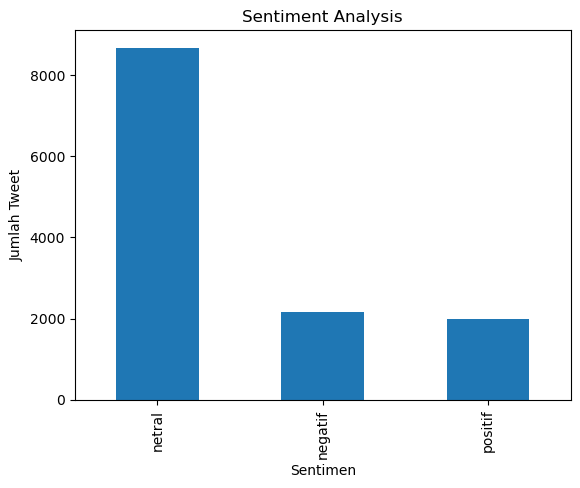

In [14]:
df['sentimen'].value_counts().plot(kind='bar', title='Sentiment Analysis', xlabel='Sentimen', ylabel='Jumlah Tweet')

In [15]:
data_negatif = df[df['sentimen'] == 'negatif']
data_positif = df[df['sentimen'] == 'positif']
data_netral = df[df['sentimen'] == 'netral']

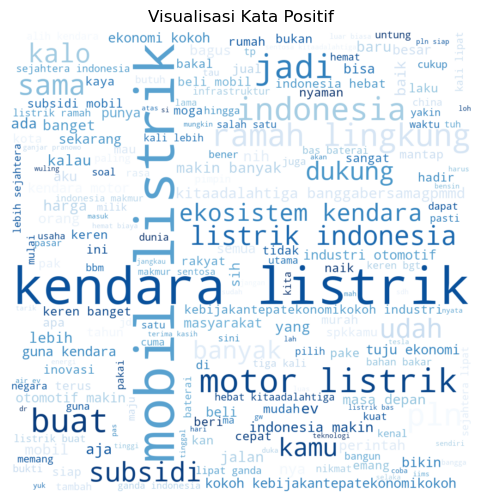

In [16]:
all_text_s1 = ' '.join(word for word in data_positif["cleaned_text"])
wordcloud = WordCloud(colormap='Blues', width=1000, height=1000, mode="RGBA", background_color='white').generate(all_text_s1)
plt.figure(figsize=(8, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Visualisasi Kata Positif")
plt.margins(x=0, y=0)
plt.show()

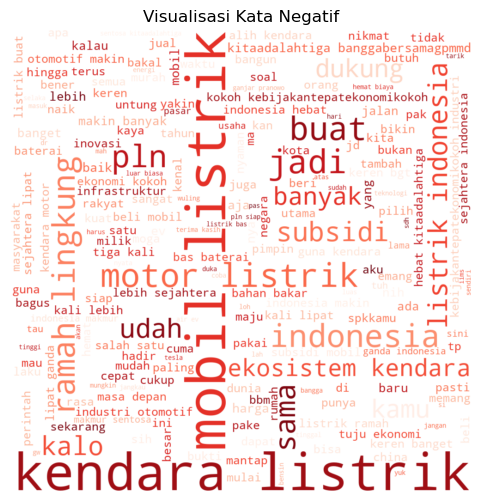

In [17]:
all_text_s2 = ' '.join(word for word in data_negatif["cleaned_text"])
wordcloud = WordCloud(colormap='Reds', width=1000, height=1000, mode="RGBA", background_color='white').generate(all_text_s1)
plt.figure(figsize=(8, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Visualisasi Kata Negatif")
plt.margins(x=0, y=0)
plt.show()

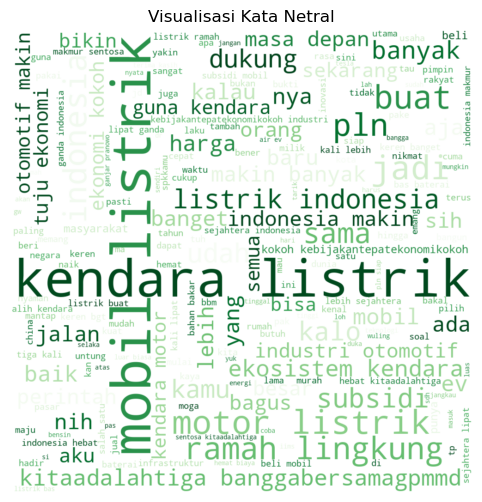

In [18]:
all_text_s3 = ' '.join(word for word in data_netral["cleaned_text"])
wordcloud = WordCloud(colormap='Greens', width=1000, height=1000, mode="RGBA", background_color='white').generate(all_text_s1)
plt.figure(figsize=(8, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Visualisasi Kata Netral")
plt.margins(x=0, y=0)
plt.show()

## LSTM

In [19]:
data = df[['cleaned_text', 'sentimen']]
data

,cleaned_text,sentimen
0,body ev buat bauksit juga milik indonesia ketu...,netral
1,baterai rupa komponen utama ev indonesia milik...,netral
2,indonesia milik semua komponen bahan dasar bua...,netral
3,ev rupa tongkat indonesia jadi dominasi dunia ...,netral
4,hadir spkkamu juga jadi perhati tamutamu negar...,netral
...,...,...
12813,subsidi mobil listrik indonesia bukan lah kamu...,netral
12814,subsidi mobil listrik batal hanya jelas subsid...,netral
12815,alas wuling harga air ev naik jelang subsidi m...,netral
12816,baru akun kenal sering diskus kena isu politik...,netral


In [20]:
data['sentimen'] = data['sentimen'].replace({
    'positif':1,
    'negatif':2,
    'netral':0
})

C:\Users\Muhammad Ade Aulia\AppData\Local\Temp\ipykernel_42756\1754949595.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['sentimen'] = data['sentimen'].replace({


In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12818 entries, 0 to 12817
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   cleaned_text  12818 non-null  object
 1   sentimen      12818 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 200.4+ KB


In [22]:
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['cleaned_text'].values)
X = tokenizer.texts_to_sequences(data['cleaned_text'].values)
X = pad_sequences(X)
X[:2]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  11,   9, 167,
         77,   4, 716],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,  10, 207, 443, 135,  11,   4,  77, 102, 104,
        916,   9, 716]])

In [23]:
embed_dim = 128
lstm_out = 196

num_classes = len(pd.unique(data['sentimen']))

model = Sequential()
model.add(Embedding(max_fatures, embed_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(Bidirectional(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

c:\Users\Muhammad Ade Aulia\miniconda3\envs\gpu_load\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [24]:
Y = pd.get_dummies(data['sentimen']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(10254, 42) (10254, 3)
(2564, 42) (2564, 3)


In [25]:
batch_size = 128
model.fit(X_train, Y_train, epochs = 20, batch_size=batch_size, verbose = 1)

Epoch 1/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 13s 106ms/step - accuracy: 0.6648 - loss: 0.8342
Epoch 2/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - accuracy: 0.7925 - loss: 0.5308
Epoch 3/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 104ms/step - accuracy: 0.8418 - loss: 0.4015
Epoch 4/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - accuracy: 0.8663 - loss: 0.3498
Epoch 5/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - accuracy: 0.8772 - loss: 0.3186
Epoch 6/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - accuracy: 0.8892 - loss: 0.2945
Epoch 7/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 0.8932 - loss: 0.2765
Epoch 8/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 0.9020 - loss: 0.2534
Epoch 9/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 12s 152ms/step - accuracy: 0.9104 - loss: 0.2425
Epoch 10/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 0.9174 - loss: 0.2253
Epoch 11/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 0.9201 - loss: 0.2135
Epoch 12/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 11s 

In [26]:
Y_pred = model.predict(X_test,batch_size = batch_size)
Y_pred_classes = np.argmax(Y_pred, axis=1)

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step


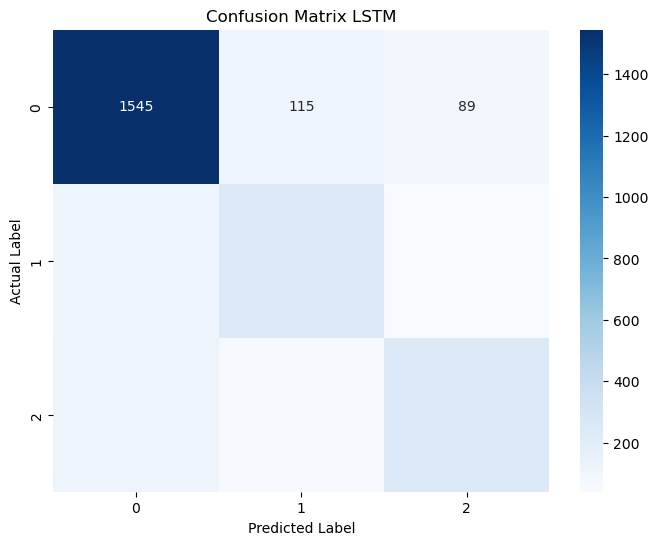

In [27]:
Y_true = np.argmax(Y_test, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(Y_true, Y_pred_classes)

# Plot
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=pd.get_dummies(data['sentimen']).columns,
            yticklabels=pd.get_dummies(data['sentimen']).columns)
plt.title('Confusion Matrix LSTM')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [29]:
conf_matrix = confusion_matrix(np.argmax(Y_test, axis=1), Y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

class_report = classification_report(np.argmax(Y_test, axis=1), Y_pred_classes)
print("Classification Report:")
print(class_report)

Confusion Matrix:
[[1545  115   89]
 [ 109  247   40]
 [ 120   46  253]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.88      0.88      1749
           1       0.61      0.62      0.61       396
           2       0.66      0.60      0.63       419

    accuracy                           0.80      2564
   macro avg       0.71      0.70      0.71      2564
weighted avg       0.80      0.80      0.80      2564

